In [33]:
from prf import *
import scipy.signal as sp
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider, Button
from scipy.interpolate import interp2d
import cv2

In [34]:
'''
Stims shape = [x, y, t, c, n] for each condition (perception, LTM, WM)
x = size
y = size
t = time points
c = cortical roi
n = number of positions
'''

size = 100
n_time = 5
n_pos = 4
target_ecc = 7
near_ecc = 1.5

v1slope = 0.23
v2slope = 0.3
v3slope = 0.39
v4slope = 0.56
slopes = [v1slope, v2slope, v3slope, v4slope]
intercept = 0.6
n_ecc = 20

origin = np.array([size/2, size/2])
radius = np.sqrt(((size/2.0)**2.0)+((size/2.0)**2.0))

n_bins = 30
all_vox = False

# Generate voxels and pRFs
v1 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v1slope, prf_intercept = intercept)
v2 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v2slope, prf_intercept = intercept)
v3 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v3slope, prf_intercept = intercept)
v4 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v4slope, prf_intercept = intercept)

cortex = [v1, v2, v3, v4]
n_regions = len(cortex)
n_voxels = len(v1)
cortex_prfmaps = np.zeros([size, size, n_voxels, len(cortex)])

for c, region in enumerate(cortex):
    for i, v in enumerate(region):
        x, y, ecc, prf_size = v
        cortex_prfmaps[:, :, i, c] = generate_prf(center = [x, y], size = size, sd = prf_size)
        

# Initialize source matrices
perception = np.zeros([size, size, n_time, n_regions, n_pos])
LTM = np.zeros(perception.shape)
WM = np.zeros(perception.shape)

# Initialize response matrices
if all_vox == False: 
    n_voxels = len(np.where((v1[:, 2] <= target_ecc + near_ecc) & \
                            (v1[:, 2] >= target_ecc - near_ecc))[0])

perc_resp = np.zeros([n_voxels, 6, n_pos, n_regions, n_time])
LTM_resp = np.zeros(perc_resp.shape)
WM_resp = np.zeros(perc_resp.shape)

# Initialize PARF matrices
perc_parf = np.zeros([n_bins-1, 2, n_regions, n_time])
LTM_parf = np.zeros(perc_parf.shape)
WM_parf = np.zeros(perc_parf.shape)

# Generate stimuli
stims, positions, angles = generate_isostim(target_ecc, n_pos, size = size)

In [47]:
'''
Generate "SOURCE" Images
'''
for t in range(n_time):
    print(t)
    for c in range(n_regions):
        # LTM
        sd = 8 - c
        filt = generate_prf_warp(size = size/2, sd = sd, y_warp = 0.9, x_warp = 1.5) 
        LTM[:, :, t, c, :] = gen_polarstims(stims, filt, origin, radius, space = 'log')  * (1 - slopes[c]) / (t+1)
        
        # WM
        sd = (t+1)*2
        filt = generate_prf_warp(size = size/2, sd = sd, y_warp = 1.5, x_warp = 0.9)
        WM[:, :, t, c, :] = gen_polarstims(stims, filt, origin, radius, space = 'log') * (1 - slopes[c])/ (t+1)
        
        # Perception
        perception[:, :, t, c, :] = stims


0
1
2
3
4


Text(0.81, 0.9, 'V4')

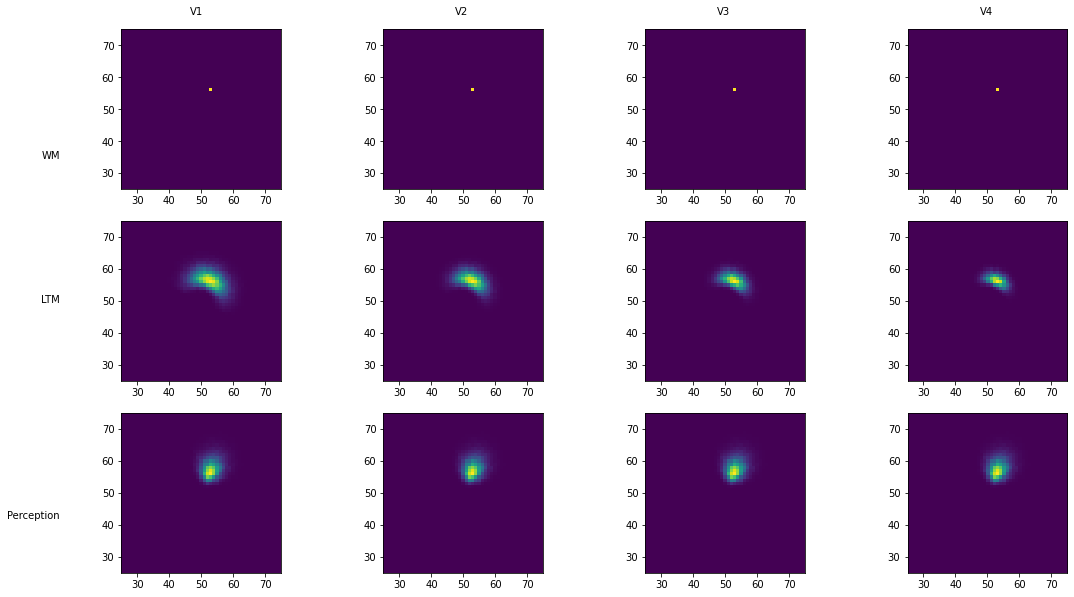

In [69]:
'''
Plot "SOURCE" Images
'''
zoom = 2
fig, axs = plt.subplots(3, n_regions)
fig.set_size_inches(18, 10)

z = size/(zoom*2)
t = 2

for c in range(n_regions):        
        axs[0, c].imshow(perception[:, :, t, c, 0])
        axs[0, c].set_ylim([size/2 - z, size/2 + z])
        axs[0, c].set_xlim([size/2 - z, size/2 + z])
        
        axs[1, c].imshow(LTM[:, :, t, c, 0])
        axs[1, c].set_ylim([size/2 - z, size/2 + z])
        axs[1, c].set_xlim([size/2 - z, size/2 + z])
        
        axs[2, c].imshow(WM[:, :, t, c, 0])
        axs[2, c].set_ylim([size/2 - z, size/2 + z])
        axs[2, c].set_xlim([size/2 - z, size/2 + z])
        

fig.text(0.1, 0.2, 'Perception', ha = 'right')
fig.text(0.1, 0.5, 'LTM', ha = 'right')
fig.text(0.1, 0.7, 'WM', ha = 'right')

fig.text(0.2, 0.9, 'V1')
fig.text(0.405, 0.9, 'V2')
fig.text(0.607, 0.9, 'V3')
fig.text(0.81, 0.9, 'V4')


In [48]:
'''
Compute prfResponses
'''
for c in range(n_regions):
    prf_maps = cortex_prfmaps[:, :, :, c]
    voxels = cortex[c]
    print(c)
    for t in range(n_time):
        P_sources = perception[:, :, t, c, :]
        L_sources = LTM[:, :, t, c, :]
        W_sources = WM[:, :, t, c, :]

        perc_resp[:, :, :, c, t] = gen_pRFresponses(near_ecc, target_ecc, P_sources, prf_maps, voxels, positions, all_vox = all_vox).squeeze()
        LTM_resp[:, :, :, c, t] = gen_pRFresponses(near_ecc, target_ecc, L_sources, prf_maps, voxels, positions, all_vox = all_vox).squeeze()
        WM_resp[:, :, :, c, t] = gen_pRFresponses(near_ecc, target_ecc, W_sources, prf_maps, voxels, positions, all_vox = all_vox).squeeze()

0
1
2
3


In [49]:
'''
Compute Polar Angle Response Functions
'''

for c in range(n_regions):
    for t in range(n_time):
        perc_parf[:, :, c, t] = parf_tuningcurve(n_bins, perc_resp[:, :, :, c, t].squeeze())
        LTM_parf[:, :, c, t] = parf_tuningcurve(n_bins, LTM_resp[:, :, :, c, t].squeeze())
        WM_parf[:, :, c, t] = parf_tuningcurve(n_bins, WM_resp[:, :, :, c, t].squeeze())
        
        

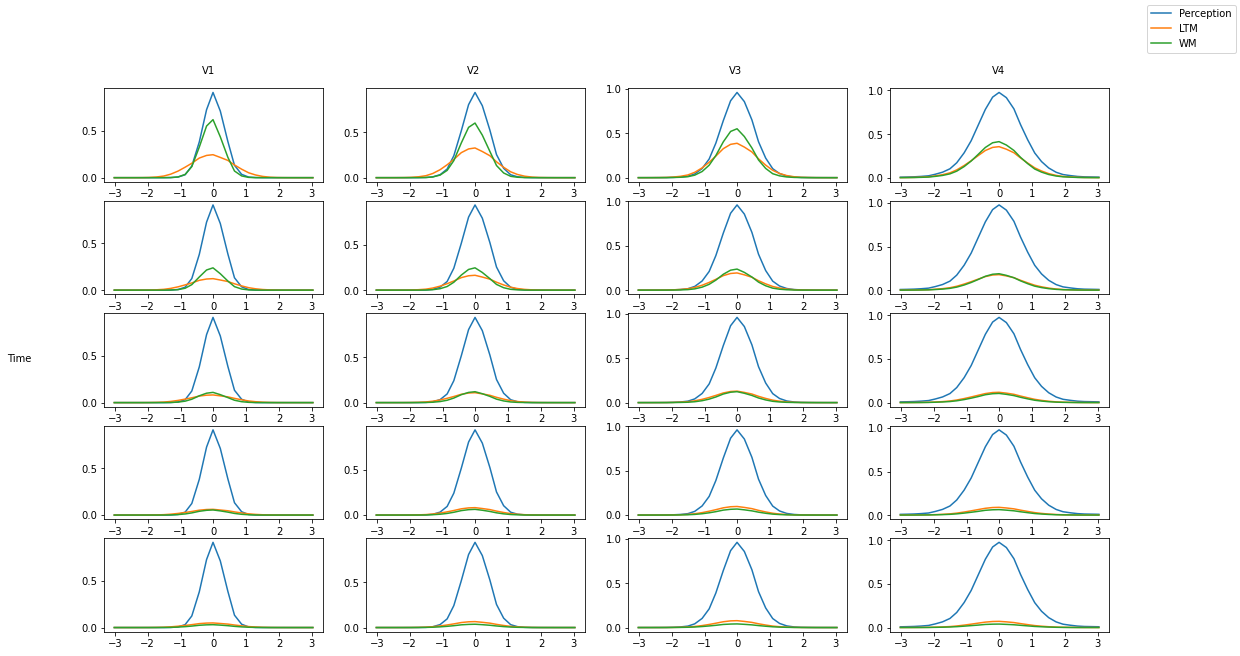

In [50]:
'''
Plot Simulations
'''
fig, axs = plt.subplots(n_time, n_regions)
fig.set_size_inches(18, 10)

for c in range(n_regions):
    for t in range(n_time):
        ax = axs[t, c]
        ax.plot(perc_parf[:, 0, c, t], perc_parf[:, 1, c, t])
        ax.plot(LTM_parf[:, 0, c, t], LTM_parf[:, 1, c, t])
        ax.plot(WM_parf[:, 0, c, t], WM_parf[:, 1, c, t])
        
fig.text(0.05, 0.5, 'Time')
fig.text(0.2, 0.9, 'V1')
fig.text(0.405, 0.9, 'V2')
fig.text(0.607, 0.9, 'V3')
fig.text(0.81, 0.9, 'V4')
fig.legend(['Perception', 'LTM', 'WM'])